In [40]:
#paquetes necesarios

import pandas as pd
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Importación de los datos

df = pd.read_excel('../data/raw/datos_crudos.xlsx').dropna()

In [42]:
df.columns = ['ano', 'evento', 'categoria', 'decreto', 'provincia', 'canton', 'latitud', 'longitud', 'tipologia', 'total']

## Análisis Exploratorio de Datos

### Pérdidas por año

In [43]:
perdidas_anuales = df.groupby("ano")['total'].sum()
print(perdidas_anuales)

ano
2005    1.588197e+11
2006    1.095010e+10
2007    1.235330e+11
2008    4.697674e+10
2009    3.106250e+11
2010    1.484200e+11
2012    5.072412e+10
2014    2.594787e+10
2015    9.101658e+10
2016    1.005880e+11
2017    3.268180e+11
2019    3.411893e+10
2020    1.293164e+11
2021    2.092316e+11
2022    2.057566e+11
2023    5.095822e+09
Name: total, dtype: float64


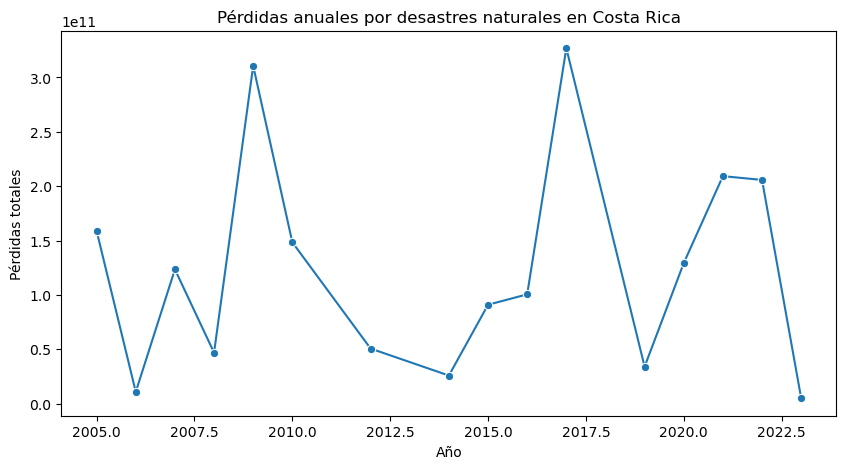

In [44]:
plt.figure(figsize=(10,5))
sns.lineplot(x=perdidas_anuales.index, y=perdidas_anuales.values, marker = 'o')
plt.title("Pérdidas anuales por desastres naturales en Costa Rica")
plt.xlabel("Año")
plt.ylabel("Pérdidas totales")
plt.show()

In [45]:
perdidas_anuales.describe()

count    1.600000e+01
mean     1.236212e+11
std      9.976533e+10
min      5.095822e+09
25%      4.376229e+10
50%      1.120605e+11
75%      1.705539e+11
max      3.268180e+11
Name: total, dtype: float64

## Pérdidas por tipología

In [46]:
df['tipologia'] = df['tipologia'].str.strip().str.upper().str.replace(r"\s+", " ", regex=True)
df['tipologia'].unique()

array(['CARRETERAS', 'VIVIENDA', 'SISTEMAS ELÉCTRICOS',
       'SISTEMAS DE INFOCOMUNICACIONES', 'PRIMER IMPACTO',
       'ALCANTARILLAS Y VADOS', 'PUENTES', 'RÍOS Y QUEBRADAS',
       'SISTEMAS DE AGUA', 'EDIFICIOS PÚBLICOS', 'CENTROS EDUCATIVOS',
       'SOCIAL', 'AGROPECUARIO', 'FERROVÍAS', 'SISTEMAS DE RIEGO',
       'DIVERSAS', 'OBRAS CORRECTIVAS', 'ACTIVIDAD EMPRESARIAL',
       'AERODROMOS', 'OBRAS DIVERSAS', 'AMBIENTE', 'ENERGÍA (POLIDUCTO)'],
      dtype=object)

In [51]:
perdidas_tipologia = df.groupby("tipologia")['total'].sum().sort_values()
print(perdidas_tipologia)

tipologia
OBRAS DIVERSAS                    1.500000e+06
ENERGÍA (POLIDUCTO)               1.475371e+08
SISTEMAS DE INFOCOMUNICACIONES    2.664852e+08
DIVERSAS                          6.995468e+08
SISTEMAS DE RIEGO                 1.585816e+09
SOCIAL                            1.853823e+09
ACTIVIDAD EMPRESARIAL             4.711754e+09
AERODROMOS                        5.888500e+09
FERROVÍAS                         6.662570e+09
PRIMER IMPACTO                    1.206046e+10
CENTROS EDUCATIVOS                2.093472e+10
AMBIENTE                          3.242022e+10
OBRAS CORRECTIVAS                 4.468168e+10
EDIFICIOS PÚBLICOS                5.136129e+10
ALCANTARILLAS Y VADOS             5.968782e+10
SISTEMAS DE AGUA                  7.141662e+10
VIVIENDA                          1.558184e+11
AGROPECUARIO                      1.919587e+11
SISTEMAS ELÉCTRICOS               2.058355e+11
PUENTES                           2.653322e+11
RÍOS Y QUEBRADAS                  3.446639e+11
CAR

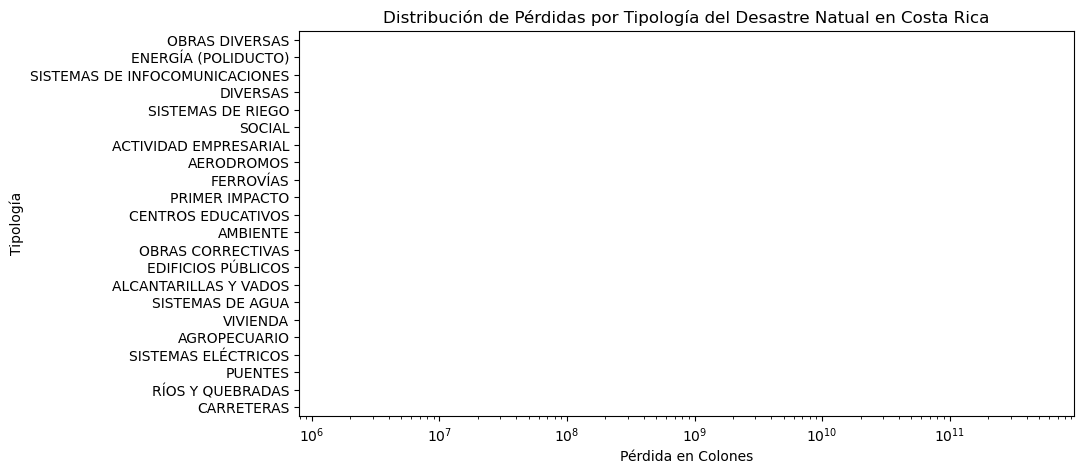

In [53]:
plt.figure(figsize=(10,5))
sns.barplot(x=perdidas_tipologia.values, y=perdidas_tipologia.index, log_scale=True)
plt.title("Distribución de Pérdidas por Tipología del Desastre Natual en Costa Rica")
plt.xlabel("Pérdida en Colones")
plt.ylabel("Tipología")
plt.show()